In [2]:
# load data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import pickle
import ipywidgets as widgets
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
from matplotlib import cm

# color maps
cmap_hot = cm.get_cmap('hot')
cmap_viridis = cm.get_cmap('viridis')
cmap_jet = cm.get_cmap('jet')

# load and process stimuli
execfile('Stimulus.py')
data_folder = "../data/"
stim_file = "Stiminfo_PVCre_2021_0012_s06_e14.csv"
stim = pd.read_csv(data_folder+stim_file)
num_trial = len(stim)

# load and process spikes
spike_times_file = "Spiketimes_PVCre_2021_0012_s06_e14.npy"
spike_times = np.load(data_folder+spike_times_file, allow_pickle=True)
active = [len(spike_times[i]) > 0 for i in range(len(spike_times))]
spike_times = spike_times[np.where(active)]
num_unit = len(spike_times)


# sort by firing rate
num_spike = list(map(len, spike_times))
spike_times = spike_times[np.argsort(num_spike)[::-1]]
execfile('load.py')

# reverse correlation time offset range 
max_delay = 300 # dt
tau_id_range = np.arange(max_delay)

# experiment duration
latest_spike_time = max([np.max(s) for s in spike_times if len(s)])
latest_stim_offtime = list(stim['stim_offtime'])[-1]
experiment_dur = max([latest_spike_time, latest_stim_offtime])

dt = 0.001 # 1 ms
exp_time = np.arange(0, experiment_dur, dt)
M = len(exp_time)

# binary spike and stimulus trains
B_stim = {}
for key in key_list:
    B_stim[key] = []
    for stim_id, trials in enumerate(stim_id_trial[key]):
        B_stim[key].append([])
        s = []
        for trial_id in trials:
            t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
            s += list(np.arange(int(t_on//dt), int(t_off//dt)))

        B_stim[key][stim_id] = sparse.coo_matrix((np.ones(len(s)), (np.zeros(len(s), dtype=int), s)), shape=(1, M))
s = spike_times//dt
B_spike = []
for unit_id in range(num_unit):
    B_spike.append(sparse.coo_matrix((np.ones(len(s[unit_id])), (np.zeros(len(s[unit_id]), dtype=int), np.int0(s[unit_id]))), shape=(1, M)))

# histogram error bars: num spikes
# spike_count = np.zeros((num_unit, 2))
# for unit_id in range(num_unit):
#     # print("unit: %d"%unit_id)
#     a = np.zeros(len(tau_id_range))
#     for tau_id in tau_id_range:
#         a[tau_id] = np.sum(B_spike[unit_id].col >= tau_id)
    
#     spike_count[unit_id] = [np.mean(a), np.std(a)]

key_symbol = {'pair':'$(\\theta,\phi)$', 'orientation':'$\\theta$', 'phase':'$\phi$'}

# 2D tuning
avg_firing_rate_pair = np.array([
    sts.zscore(stim_hist['pair'][unit_id]).reshape((len(tau_id_range), num_stim['orientation'], num_stim['phase'])) 
    for unit_id in range(num_unit)])

sorted_spike_num = np.sort(num_spike)[::-1]
cutoff_num_spike = 1000
num_unit = np.sum(sorted_spike_num > cutoff_num_spike)
for key in key_list:
    stim_hist[key] = stim_hist[key][:num_unit]



stim_data.pkl
dict_keys(['stim_val', 'trial_stim_id', 'key_list', 'num_trial', 'trial_pair_id', 'pair_val', 'pair_trial_id', 'stim_id_trial', 'num_stim'])
spike_data.pkl
dict_keys(['spike_count_rate', 'avg_firing_rate', 'sem_firing_rate', 'firing_rate', 'stim_num_trial', 'C_r_fphi_theta', 'theta_hist', 'phase_hist', 'pair_hist'])
corr_data.pkl
dict_keys(['corr_stim_unit', 'optimal_avg_firing_rate', 'stim_hist', 'stim_hist_caution'])


In [3]:
# # tuning score

# sorted_spike_num = np.sort(num_spike)[::-1]
# cutoff_num_spike = 1000
# num_unit = np.sum(sorted_spike_num > cutoff_num_spike)
# for key in key_list:
#     stim_hist[key] = stim_hist[key][:num_unit]
    
# from scipy.stats import zscore

# var_tuning = {}
# stim_hist_KL_div = {}
# for key in key_list:
#     var_tuning[key] = np.zeros((num_unit, len(tau_id_range)))
#     stim_hist_KL_div[key] = np.zeros((num_unit, len(tau_id_range)))

#     for unit_id in range(num_unit):
#         var_tuning[key][unit_id] = zscore(np.var(stim_hist[key][unit_id], axis=1))
#         for tau_id in tau_id_range:
#             p_non = (1-np.sum(stim_hist[key][unit_id, tau_id]))
#             s_non = 0
#             if p_non > 0:
#                 s_non = -p_non * np.log10(p_non)
            
#             nonzero_id = np.where(stim_hist[key][unit_id, tau_id] != 0)
#             p_stim = stim_hist[key][unit_id, tau_id, nonzero_id]
#             if np.any(p_stim<=0):
#                 print('p_stim')

#             if p_non >1 or np.any(p_stim>1):
#                 print('wrong')
                
#             s_stim = -p_stim * np.log10(p_stim)
#             ent = np.sum(s_stim) + s_non
#             if ent<0:
#                 print('negative stim_hist_KL_div')
#             # if kl < 0:
#             #     print(unit_id, tau_id, stim_id)
#             stim_hist_KL_div[key][unit_id, tau_id] =  np.log10(num_stim[key]+1) - ent # KL div

# # normalize KL div for each unit

# stim_hist_KL_div_norm = {}
# for key in key_list:
#     stim_hist_KL_div_norm[key] = zscore(stim_hist_KL_div[key], axis=1)
    
# tuning_score = {}
# for key in key_list:
#     tuning_score[key] = np.max(stim_hist_KL_div[key], axis=1)
    
# unit_tuning_order = np.argsort(tuning_score['pair'])[::-1]
# unit_tuning2rate_order = np.argsort(unit_tuning_order)

# snr = {}
# for key in key_list:
#     snr[key] = np.mean(stim_hist[key], axis=2)/np.std(stim_hist['phase'], axis=2)


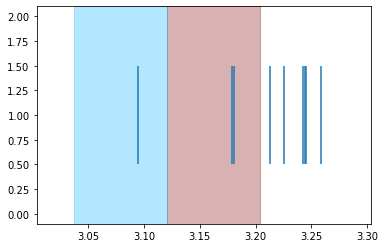

In [4]:
stim_id = 10
trial_id = stim_id_trial['phase'][stim_id][0]
unit_id = 0
t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
t0, t1 = t_off-0.2, t_off+0.1
stim_prev_id = trial_stim_id['phase'][trial_id-1]
t_prev_on, t_prev_off = stim['stim_ontime'][trial_id-1], stim['stim_offtime'][trial_id-1]
spikes = spike_times[unit_id][np.where((t0 < spike_times[unit_id]) & (spike_times[unit_id] < t1))]
plt.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
plt.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
plt.eventplot(spikes)
plt.xlim([t0, t1])
plt.show()

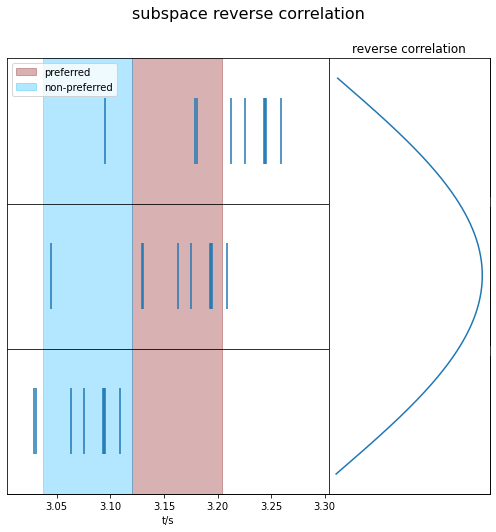

In [5]:
from matplotlib import gridspec

fig, ax = plt.subplots(3,1,figsize=(7,7))
gs0 = gridspec.GridSpec(3, 3, figure=fig, hspace=0, wspace=0)

stim_id = 10
trial_id = stim_id_trial['phase'][stim_id][0]
unit_id = 0
t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
t0, t1 = t_off-0.2, t_off+0.1
stim_prev_id = trial_stim_id['phase'][trial_id-1]
t_prev_on, t_prev_off = stim['stim_ontime'][trial_id-1], stim['stim_offtime'][trial_id-1]
spikes = spike_times[unit_id][np.where((t0 < spike_times[unit_id]) & (spike_times[unit_id] < t1))]

ax0 = fig.add_subplot(gs0[0, :-1])
ax1 = fig.add_subplot(gs0[1, :-1])
ax2 = fig.add_subplot(gs0[2, :-1])
ax3 = fig.add_subplot(gs0[:, -1])

ax0.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3, label='preferred')
ax0.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3, label='non-preferred')
ax0.eventplot(spikes)
ax0.set_xlim([t0, t1])
ax0.legend(loc='upper left')

ax1.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
ax1.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax1.eventplot(spikes-0.05)
ax1.set_xlim([t0, t1])

ax2.axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
ax2.axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax2.eventplot(spikes-0.15)
ax2.set_xlim([t0, t1])

ax3.plot(np.sin(np.pi*tau_id_range/300), np.arange(300))
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('reverse correlation')
# ax2.legend()
for ax in fig.get_axes():
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

ax2.tick_params(bottom=True, labelbottom=True)
ax2.set_xlabel('t/s')
plt.tight_layout()
fig.suptitle('subspace reverse correlation', size=16, y=1.05)
plt.show()


In [6]:
# # subspace reverese correlation
# fig, ax = plt.subplots(2,1,figsize=(7,7))
# stim_id = 13
# trial_id = stim_id_trial['phase'][stim_id][0]-3
# stim_id = trial_stim_id['phase'][trial_id]
# unit_id = 0
# t_on, t_off = stim['stim_ontime'][trial_id], stim['stim_offtime'][trial_id]
# t0, t1 = t_off-0.5, t_off+0.5
# stim_prev_id = trial_stim_id['phase'][trial_id-1]
# t_prev_on, t_prev_off = stim['stim_ontime'][trial_id-1], stim['stim_offtime'][trial_id-1]
# spikes = spike_times[unit_id][np.where((t_off-0.5 < spike_times[unit_id]) & (spike_times[unit_id] < t_off+0.2))]
# ax[0].axvspan(t_on, t_off, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
# ax[0].axvspan(t_prev_on, t_prev_off, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
# ax[0].eventplot(spikes)
# ax[0].set_xlim([t0, t1])
# ax[1].plot(np.arange(t0, t1, dt), step_stim[int(t0//dt): int(t1//dt)])
# # ax[1].plot(np.arange(t0, t1), step_stim[int(t0//dt): int(t1//dt)])

# ax[1].set(ylabel='phase', xlabel='time')
# plt.show()

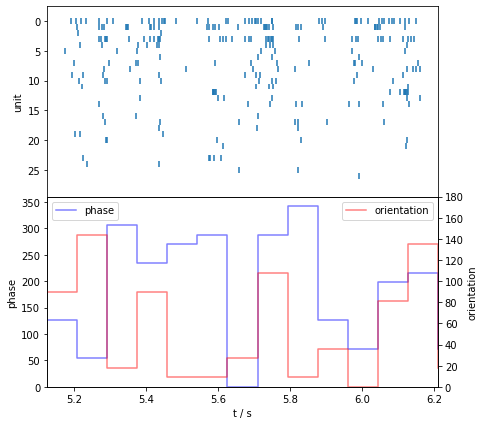

In [7]:
# subspace reverese correlation
stim_id = 13
ref_trial_id = stim_id_trial['phase'][stim_id][0]
stim_prev_id = trial_stim_id['phase'][ref_trial_id-1]
past_trials = 3
future_trials = 10
trial_range = np.arange(-past_trials,future_trials+1) + ref_trial_id

units = np.arange(num_unit)
orientation, phase, t_on = np.array(stim[['grat_orientation', 'grat_phase','stim_ontime']].iloc[trial_range]).T
spikes = [spike_times[unit_id][np.where((t_on[0] < spike_times[unit_id]) & (spike_times[unit_id] < t_on[-1]))] for unit_id in units]

fig, ax = plt.subplots(2,1,figsize=(7,7))
plt.subplots_adjust(hspace=0)
s = 1
ax[0].eventplot(spikes, linelength=s, lineoffsets=s)

ref_id = list(trial_range).index(ref_trial_id)
# ax[0].axvspan(t_on[ref_id], t_on[ref_id]+0.08, color=cmap_jet(1-np.abs(stim_id-10)/10), alpha=0.3)
# ax[0].axvspan(t_on[ref_id-1], t_on[ref_id-1]+0.08, color=cmap_jet(1-np.abs(stim_prev_id-10)/10), alpha=0.3)
ax[0].set(ylabel='unit')
ax[0].invert_yaxis()
ax[1].step(t_on, phase, 'b', where='post', alpha=0.5, label='phase')
ax[1].set(xlabel='t / s', xlim=[t_on[0], t_on[-1]], ylim=[0, 360], ylabel='phase')
ax[1].legend(loc='upper left')
ax2 = ax[1].twinx()
ax2.step(t_on, orientation, 'r', where='post', alpha=0.5, label='orientation')
ax2.set(ylim=[0, 180], ylabel='orientation')
ax2.legend()

plt.show()

### Phase reference changes with orientation

In [8]:
from tqdm import trange
import sys
sys.path.insert(0, './Persistent_Homology')
sys.path.insert(0, '../numerical')

import gratings
import decorator

In [10]:
%matplotlib inline
@widgets.interact(
 stim_theta = widgets.FloatSlider(0, min=0, max=180, step=5),
 stim_phi = widgets.FloatSlider(90, min=0, max=360, step=10),
 stim_freq = widgets.FloatSlider(1.5, min=0, max=10, step=0.5),
 RF_theta = widgets.FloatSlider(0, min=0, max=180, step=5),
 RF_phi = widgets.FloatSlider(90, min=0, max=360, step=10),
 RF_freq = widgets.FloatSlider(1.5, min=0, max=10, step=0.5),
 RF_radius = widgets.FloatSlider(0.5, min=0, max=1, step=0.1), 
 RF_x = widgets.FloatSlider(0.5, min=-1, max=1, step=0.1),
 RF_y = widgets.FloatSlider(-0.5, min=-1, max=1, step=0.1)
 )

def plot_grating(stim_theta, stim_phi, stim_freq, RF_theta, RF_phi, RF_freq, RF_radius, RF_x, RF_y):
    stim_grating = (stim_theta/180*np.pi, stim_freq, stim_phi/180*np.pi, 1)
    RF_grating = (RF_theta/180*np.pi, RF_freq, RF_phi/180*np.pi, 1)
    stim_grat_image = gratings.grating_image(grating=stim_grating, plot=False)
    RF_grat_image = gratings.grating_image(grating=RF_grating, gabor=True, rf_sigma=RF_radius, center=(RF_y, RF_x), plot=False)
    
    fig, ax = plt.subplots(1,5, figsize=(25,6))

    ax[0].imshow(stim_grat_image,"gray", vmin = -1, vmax = 1, extent=[-1,1,1,-1]) 
    receptive_field = plt.Circle((RF_x, RF_y), RF_radius, color='b', fill=False)
    ax[0].add_patch(receptive_field)
    ax[0].legend([receptive_field], ['receptive field'])
    ax[0].invert_yaxis()

    ax[1].imshow(RF_grat_image,"gray", vmin = -1, vmax = 1, extent=[-1,1,1,-1]) 
    receptive_field = plt.Circle((RF_x, RF_y), RF_radius, color='b', fill=False)
    ax[1].add_patch(receptive_field)
    ax[1].legend([receptive_field], ['receptive field'])    
    ax[1].invert_yaxis()

    response = gratings.response(RF_grating, stim_grating, rf_sigma=RF_radius, center=(RF_y, RF_x))
    ax[2].axhline(response)
    ax[2].set(ylim=[0,1])

    # Nstim = (20, 1, 20, 1)
    # stim_list = gratings.get_locations(Nstim)
    # rates = np.zeros([len(stim_list)])
    # iterator = trange(0, len(stim_list), position=0, leave=True)
    # iterator.set_description("Simulating data stim_list")
    # for i in iterator:
    #     rates[i] = response(stim_list[i], RF_grating, rf_sigma=RF_radius, center=(RF_y, RF_x))

    plt.show()

interactive(children=(FloatSlider(value=0.0, description='stim_theta', max=180.0, step=5.0), FloatSlider(value…

### Stimulus pair sequence (History or change dependence)

In [9]:
def coarse_grain(stim_range):
    

SyntaxError: incomplete input (619742353.py, line 2)

In [ ]:
# # sort by tuning score
# for key in key_list:

#     stim_hist[key] = stim_hist[key][unit_tuning_order]
#     stim_hist_KL_div[key] = stim_hist_KL_div[key][unit_tuning_order]
#     stim_hist_KL_div_norm[key] = stim_hist_KL_div_norm[key][unit_tuning_order]
#     tuning_score[key] = tuning_score[key][unit_tuning_order]
#     var_tuning[key] = var_tuning[key][unit_tuning_order]
#     snr[key] = snr[key][unit_tuning_order]

# s = s[:num_unit][unit_tuning_order]

In [11]:
%matplotlib inline

@widgets.interact(key=widgets.RadioButtons(options=key_list[1:],
    description='stimulus:',
    disabled=False), tau_id=widgets.IntSlider(0, min=0, max=max_delay-1, description='delay/ms'), unit_id=widgets.IntSlider(0, min=0, max=num_unit-1))

def PSSH(tau_id, unit_id, key):
    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    prob = stim_hist[key][unit_id, tau_id]
    n = sorted_spike_num[unit_id]
    confidence_interval = np.sqrt(prob/n)
    plt.errorbar(stim_val[key], stim_hist[key][unit_id, tau_id], yerr=confidence_interval)
    ymin = np.min(stim_hist[key][unit_id])*0.95
    ymax = np.max(stim_hist[key][unit_id])*1.05
    ax.set_ylabel('$\mathcal{P}($'+key_symbol[key]+'$|\\tau)$')
    ax.set_xlabel(key_symbol[key])
    plt.ylim([ymin, ymax])
    plt.suptitle('distribution of stimulus at time $\\tau$ before a spike of unit: %d'%unit_id)
    plt.show()

interactive(children=(IntSlider(value=0, description='delay/ms', max=299), IntSlider(value=0, description='uni…

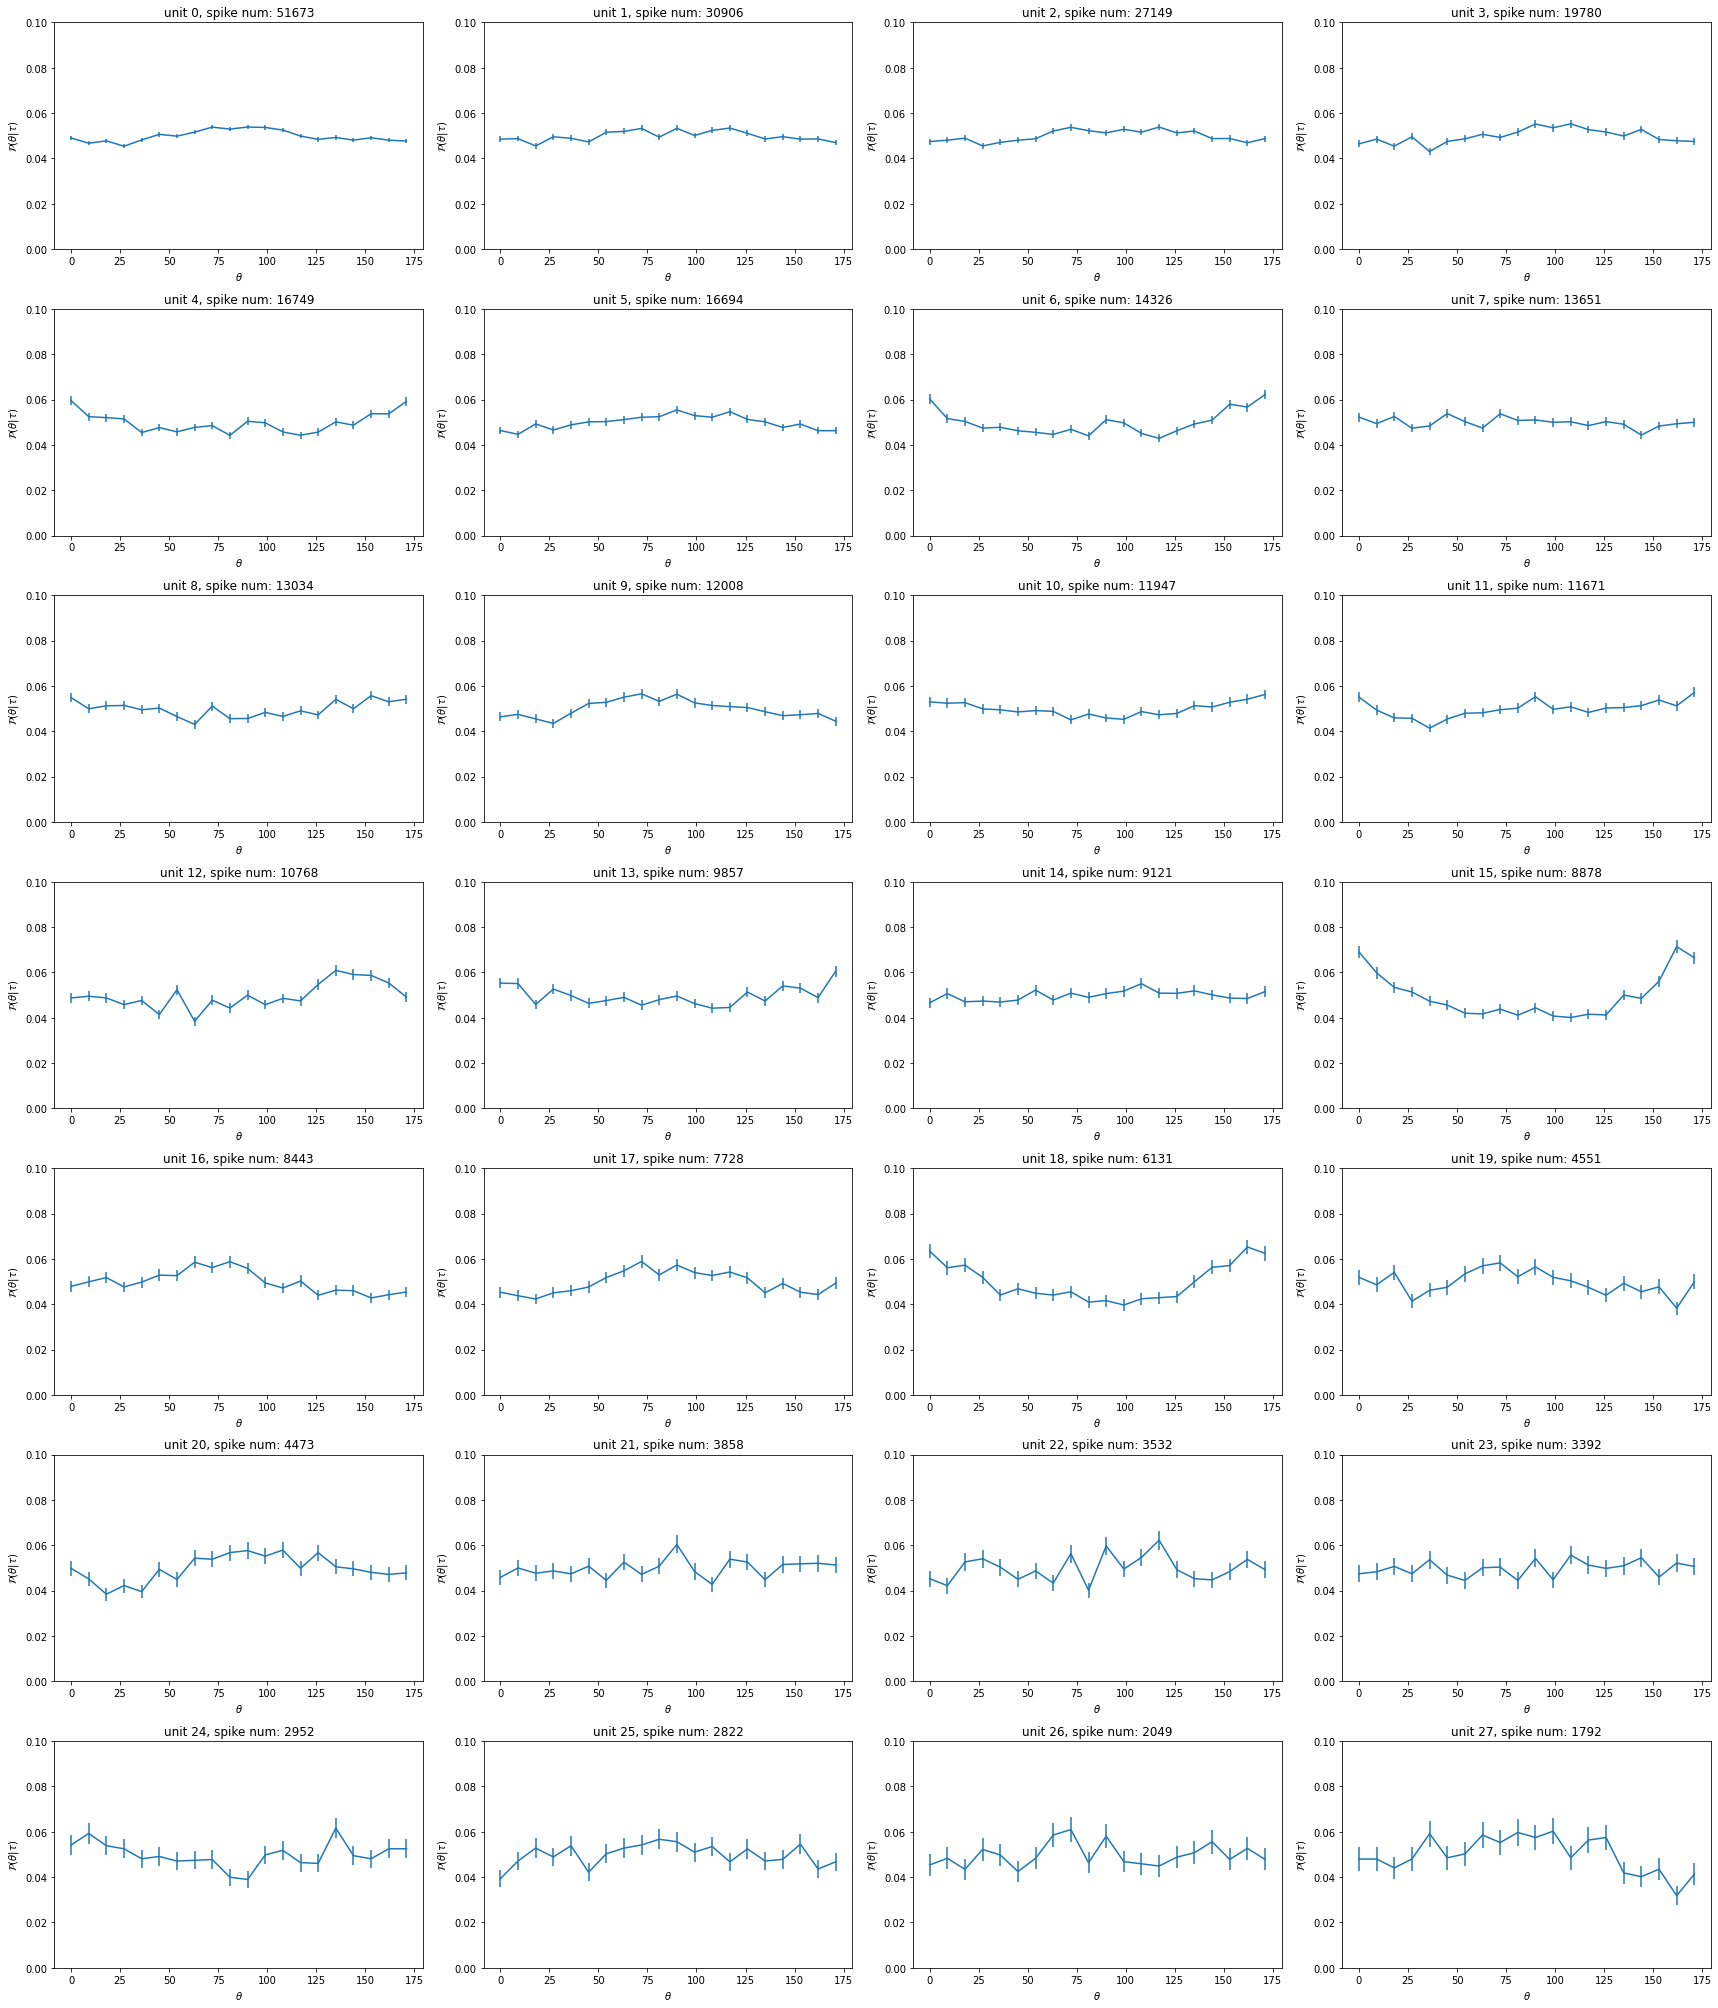

In [ ]:
%matplotlib inline

tau_id = 100
key = 'orientation'
fig, ax = plt.subplots(7,4,figsize=(6*4, 7*4))
X, Y = np.meshgrid(stim_val[key], tau_id_range)
plt.set_cmap('jet')
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].errorbar(stim_val[key], stim_hist[key][unit_id, tau_id], yerr=np.sqrt(stim_hist[key][unit_id, tau_id]/sorted_spike_num[unit_id]))
    ax[unit_id//4, unit_id%4].set_xlabel(key_symbol[key]+'/degrees')
    ax[unit_id//4, unit_id%4].set_ylabel('$\\tau/(ms)$')
    ymin = np.min(stim_hist[key][unit_id])*0.95
    ymax = np.max(stim_hist[key][unit_id])*1.05
    ax[unit_id//4, unit_id%4].set_ylabel('$\mathcal{P}($'+key_symbol[key]+'$|\\tau)$')
    ax[unit_id//4, unit_id%4].set_xlabel(key_symbol[key])
    # ax[unit_id//4, unit_id%4].set_ylim([ymin, ymax])
    ax[unit_id//4, unit_id%4].set_ylim([0, 0.1])
    ax[unit_id//4, unit_id%4].set_title('unit %d'%unit_id + ', spike num: %d'%sorted_spike_num[unit_id])

plt.tight_layout()
plt.show()

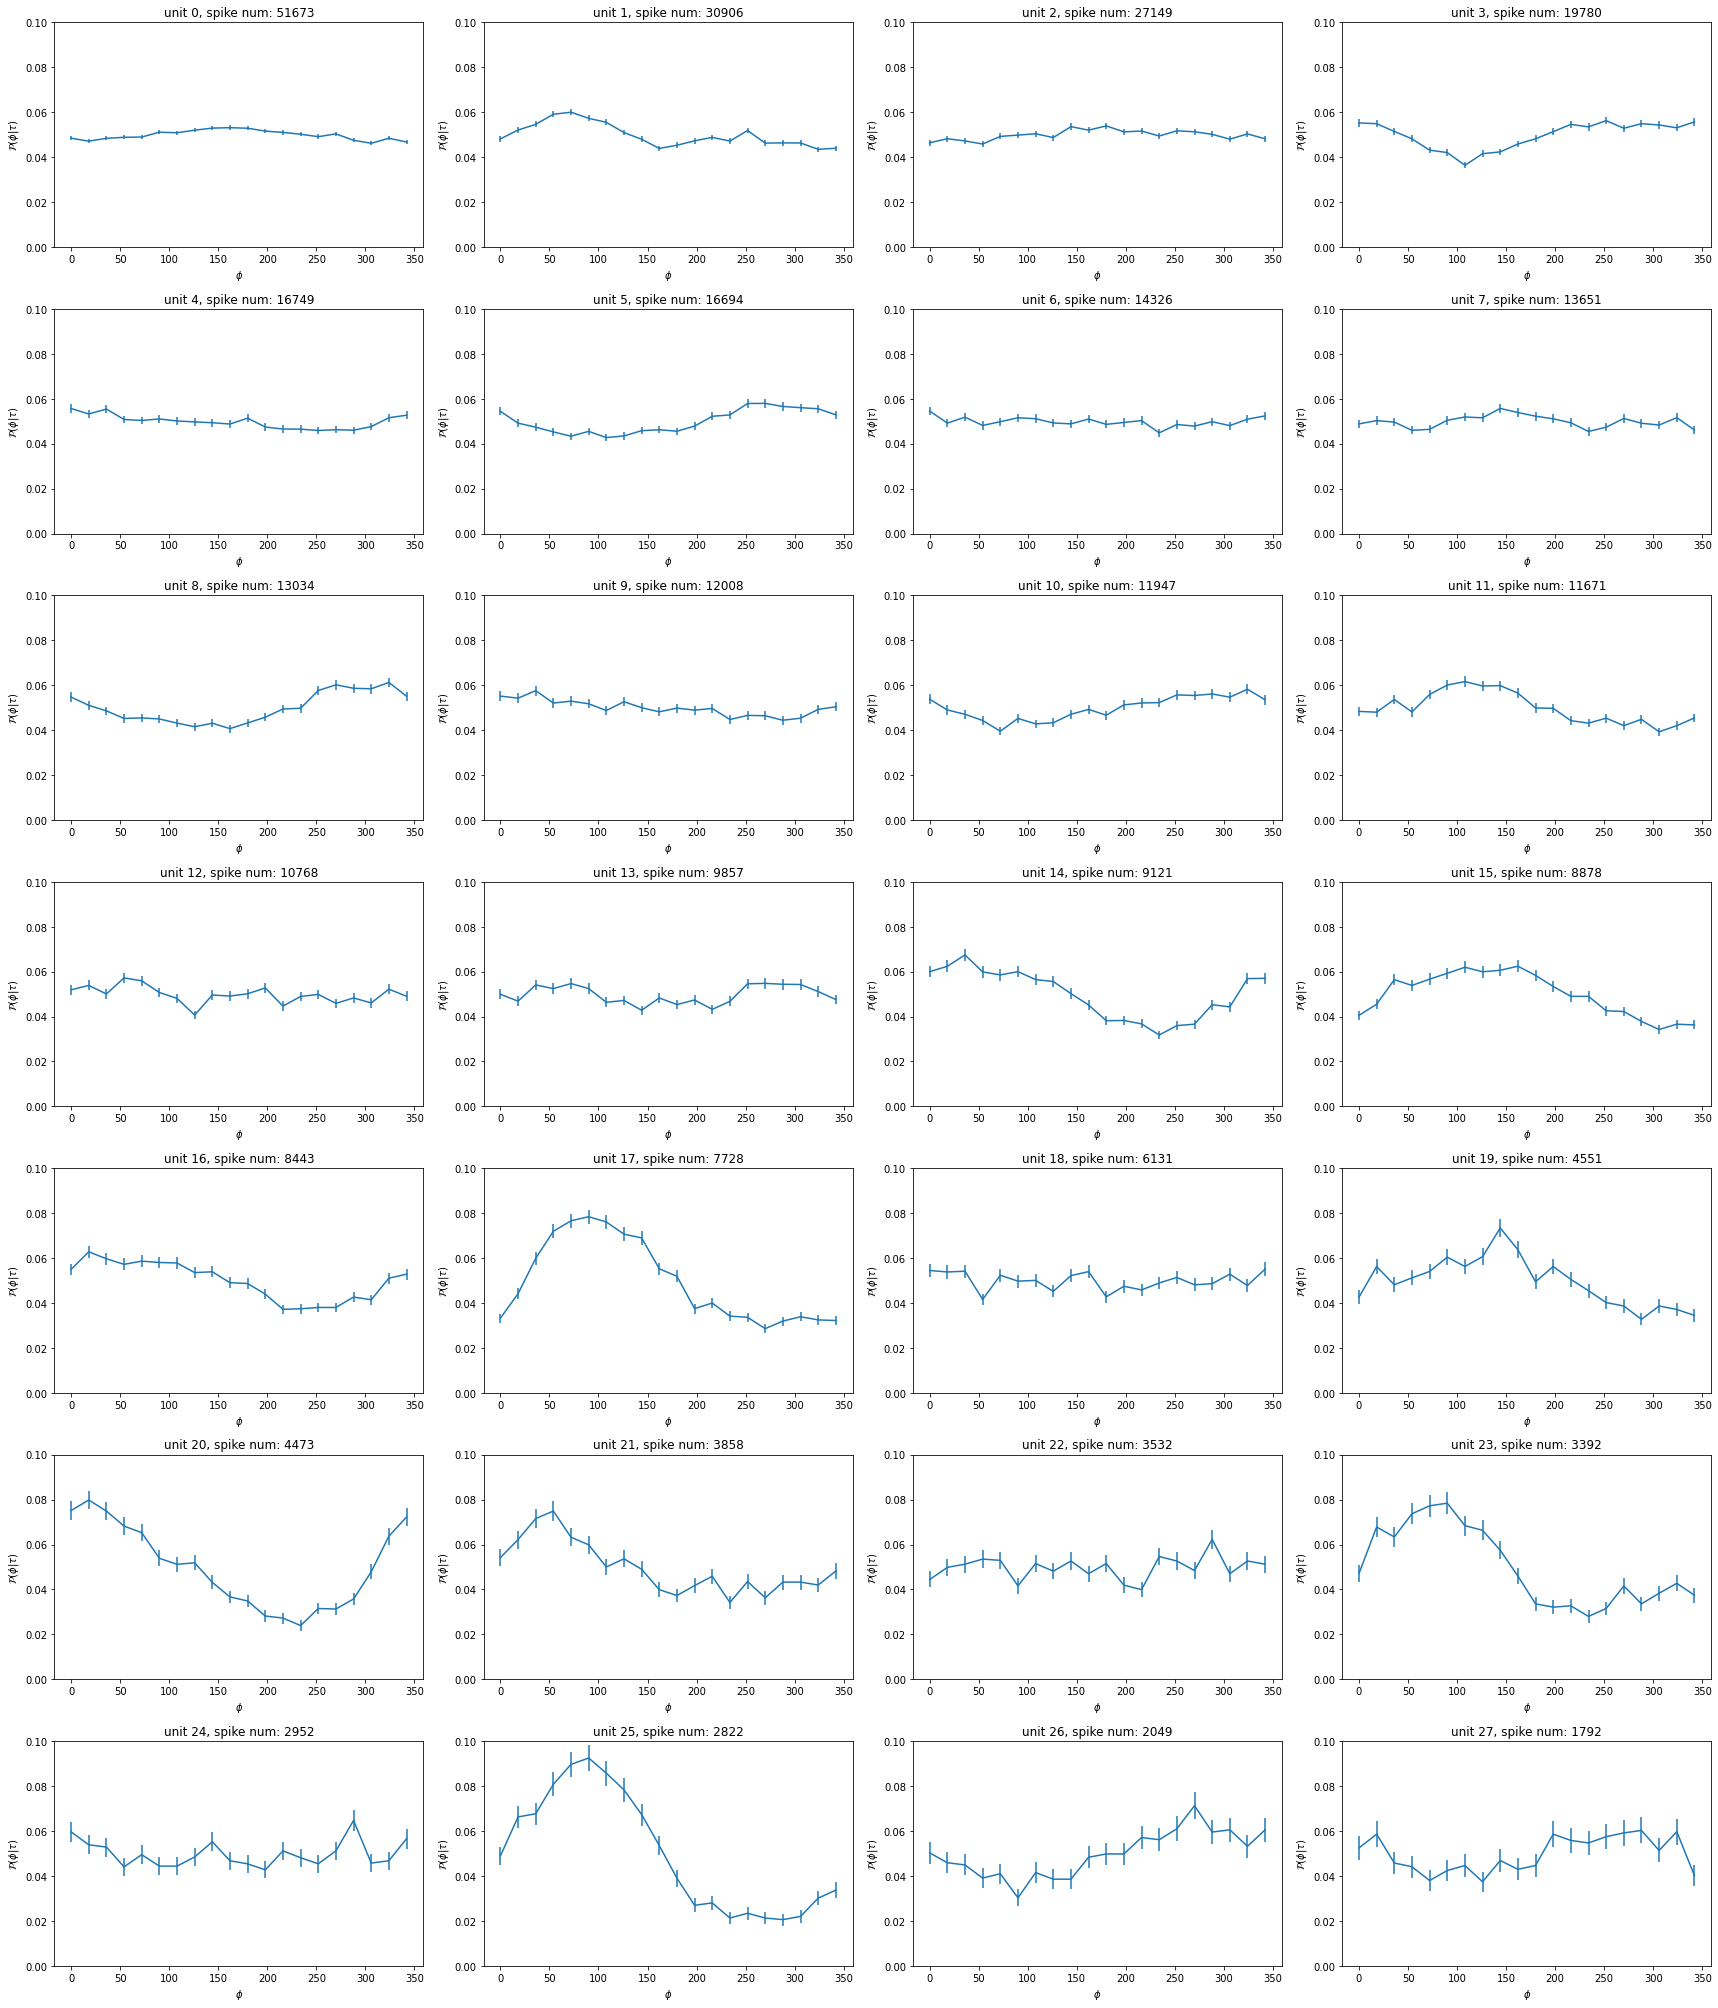

In [ ]:
%matplotlib inline

key = 'phase'
fig, ax = plt.subplots(7,4,figsize=(6*4, 7*4))
X, Y = np.meshgrid(stim_val[key], tau_id_range)
plt.set_cmap('jet')
tau_id = 60
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].errorbar(stim_val[key], stim_hist[key][unit_id, tau_id], yerr=np.sqrt(stim_hist[key][unit_id, tau_id]/sorted_spike_num[unit_id]))
    ax[unit_id//4, unit_id%4].set_xlabel(key_symbol[key]+'/degrees')
    ax[unit_id//4, unit_id%4].set_ylabel('$\\tau/(ms)$')
    ymin = np.min(stim_hist[key][unit_id])*0.95
    ymax = np.max(stim_hist[key][unit_id])*1.05
    ax[unit_id//4, unit_id%4].set_ylabel('$\mathcal{P}($'+key_symbol[key]+'$|\\tau)$')
    ax[unit_id//4, unit_id%4].set_xlabel(key_symbol[key])
    ax[unit_id//4, unit_id%4].set_ylim([0, 0.1])
    ax[unit_id//4, unit_id%4].set_title('unit %d'%unit_id + ', spike num: %d'%sorted_spike_num[unit_id])

plt.tight_layout()
plt.show()

In [ ]:

# @widgets.interact(key=widgets.RadioButtons(options=key_list[1:],
#     description='stimulus:',
#     disabled=False), unit_id=widgets.IntSlider(0, min=0, max=num_unit-1))

# def tuning_curve_time_evolution(unit_id, key):
#     fig, ax = plt.subplots(1,1)
#     from matplotlib import cm
#     cmap = cm.get_cmap('hot')

#     for tau_id in tau_id_range:
#         ax.plot(stim_val[key], stim_hist[key][unit_id, tau_id], c=cmap(tau_id))
#         ax.set_xlabel(key_symbol[key])
#         ax.set_ylabel('$P($'+key_symbol[key]+'$|\\tau)$')

#     plt.show()

In [ ]:

@widgets.interact(tau_id = widgets.IntSlider(0, min=0, max=max_delay-1, description='delay/ms'), unit_id = widgets.IntSlider(0, min=0, max=num_unit-1))

def TwoDimTuning(tau_id, unit_id):
    min_2d = np.min(avg_firing_rate_pair[unit_id])
    max_2d = np.max(avg_firing_rate_pair[unit_id])
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    im = ax.imshow(avg_firing_rate_pair[unit_id, tau_id], interpolation='None', cmap='jet', vmin=min_2d, vmax=max_2d)

    ax.set_xticks(np.arange(20)[::5])
    ax.set_xticklabels(stim_val['phase'][::5])
    ax.set_yticks(np.arange(20)[::5])
    ax.set_yticklabels(stim_val['orientation'][::5])
    ax.set_xlabel('phase')
    ax.set_ylabel('orientation')
    plt.show()

interactive(children=(IntSlider(value=0, description='delay/ms', max=299), IntSlider(value=0, description='uni…

In [ ]:
@widgets.interact(key=widgets.RadioButtons(
    options=key_list[1:],
    description='stimulus:',
    disabled=False),
    stim_id=widgets.IntSlider(0, min=0, max=19), 
    unit_id=widgets.IntSlider(0, min=0, max=num_unit-1))

def PSSH(stim_id, unit_id, key):
    ymin = np.min(stim_hist[key][unit_id])*0.95
    ymax = np.max(stim_hist[key][unit_id])*1.05

    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    ax.errorbar(tau_id_range, stim_hist[key][unit_id, :, stim_id], yerr=np.sqrt(stim_hist[key][unit_id, :, stim_id]/sorted_spike_num[unit_id]), 
    label=key_symbol[key]+'=%d'%stim_val[key][stim_id]+'$^\circ$')
    ax.set_ylim([ymin, ymax])
    ax.set_ylabel('$\mathcal{P}($'+key_symbol[key]+'$|\\tau)$')
    ax.set_xlabel('$\\tau/ms$')
    ax.legend()
    plt.show()


interactive(children=(IntSlider(value=0, description='stim_id', max=19), IntSlider(value=0, description='unit_…

In [ ]:
%matplotlib inline

key = 'pair'
@widgets.interact(phi=widgets.IntSlider(0, min=0, max=19), theta=widgets.IntSlider(0, min=0, max=19), unit_id=widgets.IntSlider(0, min=0, max=num_unit-1))

def PSSH(phi, theta, unit_id):
    ymin = np.min(stim_hist[key][unit_id])*0.95
    ymax = np.max(stim_hist[key][unit_id])*1.05

    stim_id = int(20*theta + phi)
    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    ax.errorbar(tau_id_range, stim_hist[key][unit_id, :, stim_id], yerr=np.sqrt(stim_hist[key][unit_id, :, stim_id]/sorted_spike_num[unit_id]),
    label=key_symbol[key]+'=(%d'%stim_val['orientation'][theta]+'$^\circ$,%d'%stim_val['phase'][phi]+'$^\circ)$')
    ax.set_ylim([ymin, ymax])
    ax.set_ylabel('$\mathcal{P}((\\theta, \phi)|\\tau)$')
    ax.set_xlabel('$\\tau/ms$')
    ax.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='phi', max=19), IntSlider(value=0, description='theta', m…

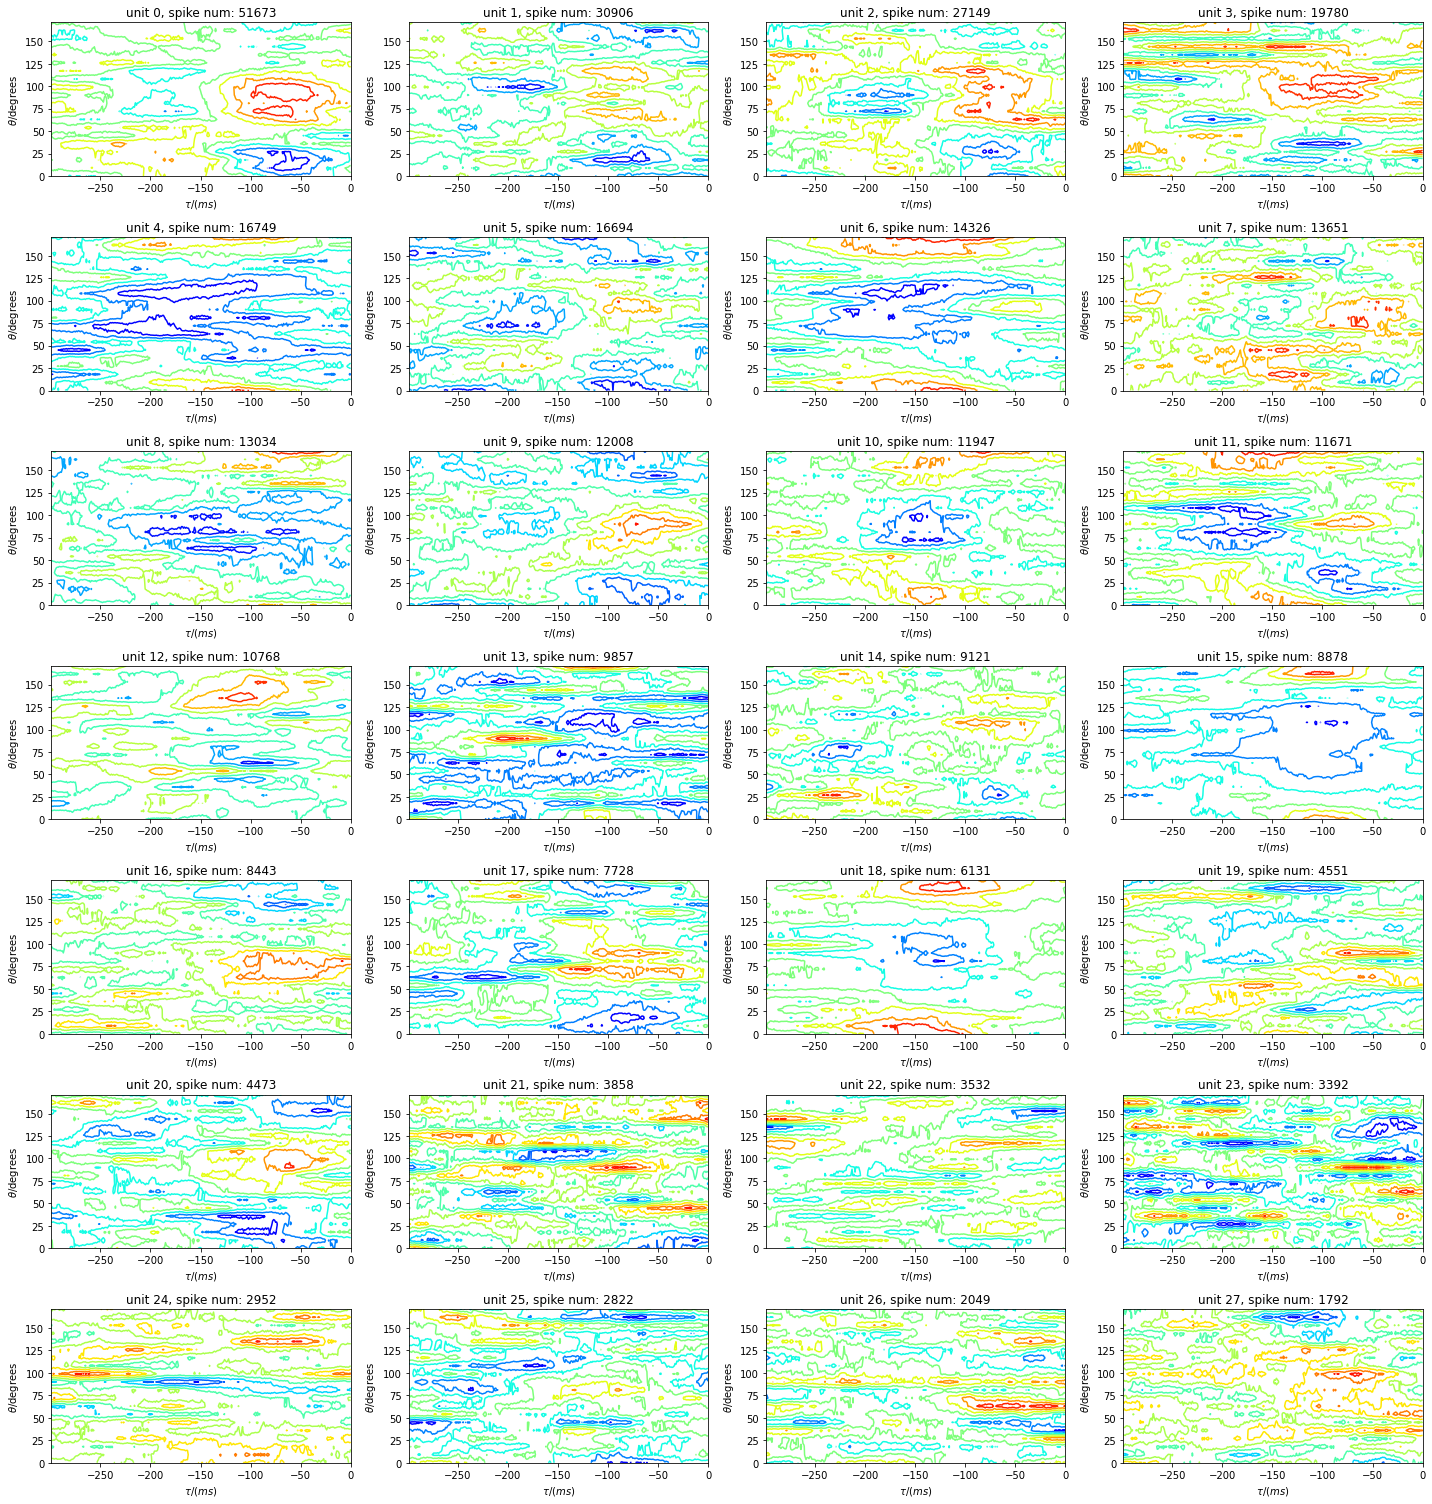

In [ ]:
# %matplotlib inline
# %matplotlib widget
# @widgets.interact(key=widgets.RadioButtons(
#     options=key_list[1:],
#     description='stimulus:',
#     disabled=False),
#     unit_id=widgets.IntSlider(0, min=0, max=num_unit-1))

# def contour_plot(key, unit_id):
#     fig = plt.figure(figsize=(8,8))
#     # ax = plt.axes(projection='3d', [0,0,0])
#     ax = plt.axes()
#     X, Y = np.meshgrid(np.arange(20), tau_id_range)
#     ax.contour(X, Y, stim_hist[key][unit_id], cmap='jet')
#     ax.set_xlabel(key_symbol[key])
#     ax.set_ylabel('$\\tau$')
#     # ax.set_zlabel('$\mathcal{P}($'+key_symbol[key]+'$|\\tau)$')
#     plt.show()

%matplotlib inline

key = 'orientation'
fig, ax = plt.subplots(7,4,figsize=(4*5, 7*3))
X, Y = np.meshgrid(stim_val[key], -tau_id_range)
plt.set_cmap('jet')
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].contour(Y, X, stim_hist[key][unit_id])
    ax[unit_id//4, unit_id%4].set_ylabel(key_symbol[key]+'/degrees')
    ax[unit_id//4, unit_id%4].set_xlabel('$\\tau/(ms)$')
    ax[unit_id//4, unit_id%4].set_title('unit %d'%unit_id + ', spike num: %d'%sorted_spike_num[unit_id])

plt.tight_layout()
plt.show()

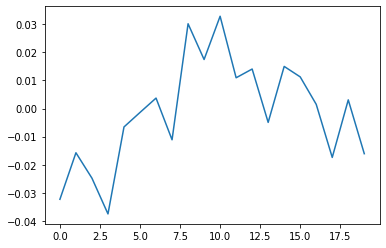

In [ ]:
# plt.imshow((np.log10(stim_hist['pair'][unit_id]*num_stim[key])[60]).reshape(20,20))
plt.plot(np.log10(stim_hist['phase'][unit_id]*num_stim[key])[60])

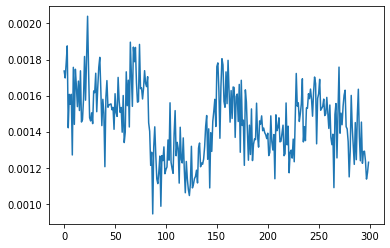

In [ ]:
plt.plot(-np.mean(np.log10(stim_hist['phase'][unit_id]*num_stim[key]), axis=1))

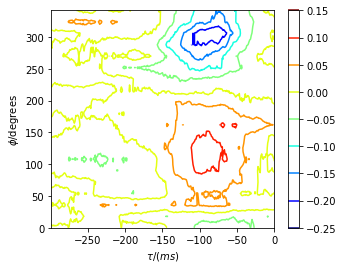

In [ ]:
%matplotlib inline

key = 'phase'
unit_id = 5
fig, ax = plt.subplots(1,1,figsize=(5, 4))
X, Y = np.meshgrid(stim_val[key], -tau_id_range)
plt.set_cmap('jet')
im = ax.contour(Y, X, np.log10(stim_hist[key][unit_id]*num_stim[key]))
ax.set_ylabel(key_symbol[key]+'/degrees')
ax.set_xlabel('$\\tau/(ms)$')
fig.colorbar(im)

plt.show()

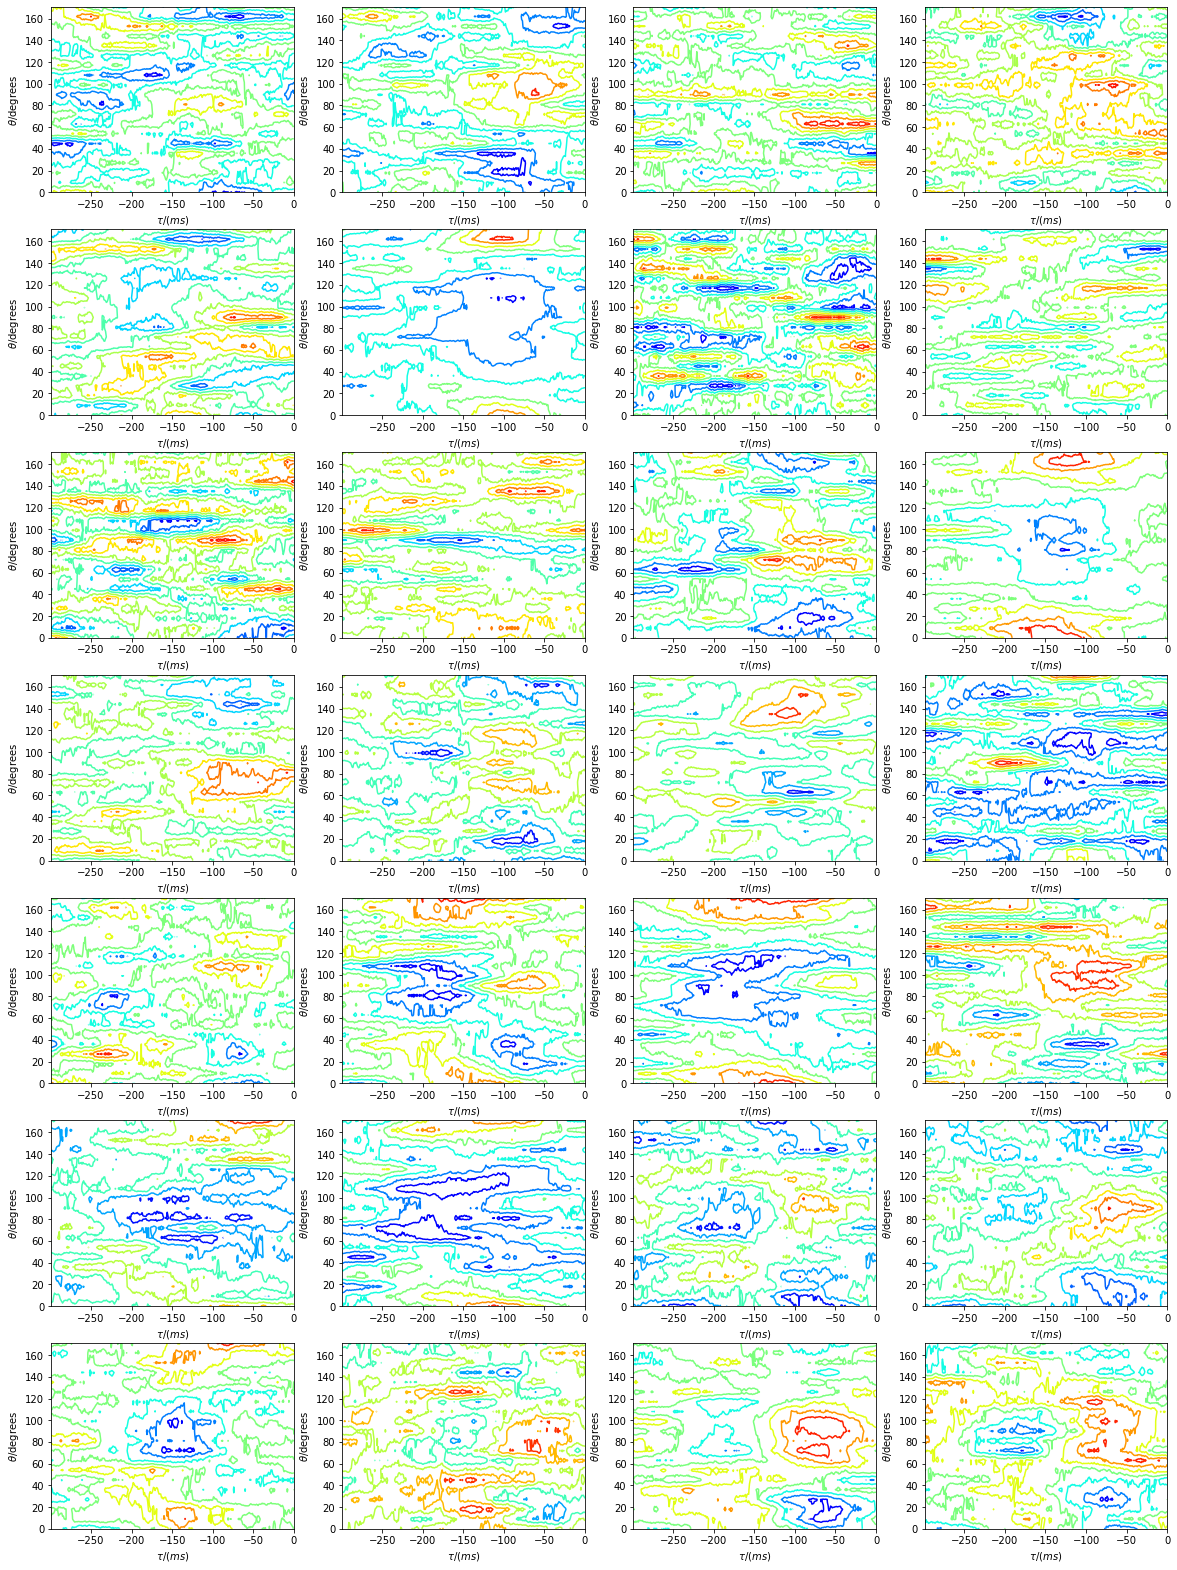

In [ ]:
%matplotlib inline

key = 'orientation'
fig, ax = plt.subplots(7,4,figsize=(5*4, 7*4))
X, Y = np.meshgrid(stim_val[key], -tau_id_range)
plt.set_cmap('jet')
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].contour(Y, X, stim_hist[key][unit_id])
    ax[unit_id//4, unit_id%4].set_ylabel(key_symbol[key]+'/degrees')
    ax[unit_id//4, unit_id%4].set_xlabel('$\\tau/(ms)$')

plt.show()

In [ ]:
var_tuning = {}
for key in key_list:
    var_tuning[key] = np.zeros((num_unit, len(tau_id_range)))
    for unit_id in range(num_unit):
        var_tuning[key][unit_id] = np.var(stim_hist[key][unit_id], axis=1)

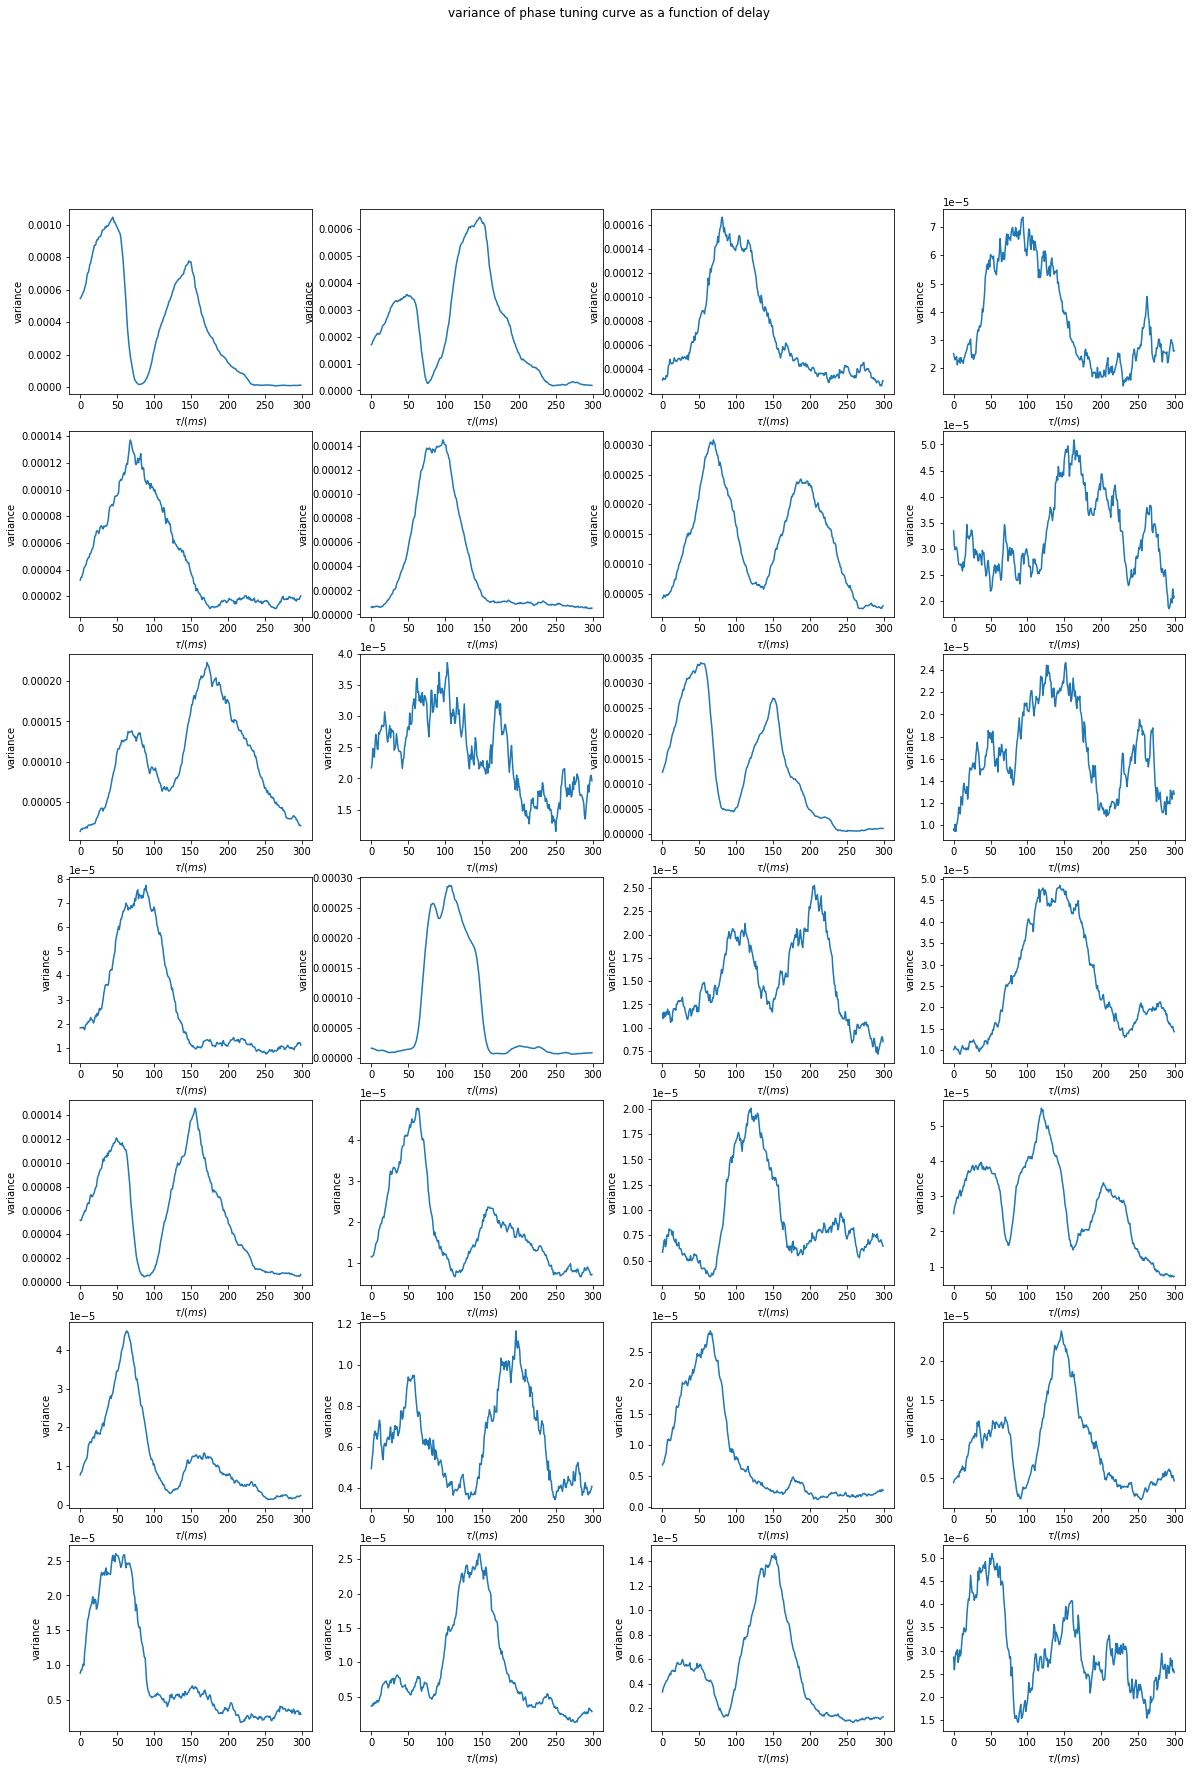

In [ ]:
%matplotlib inline

key = 'phase'
fig, ax = plt.subplots(7,4,figsize=(5*4, 7*4))
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].plot(var_tuning[key][unit_id])
    ax[unit_id//4, unit_id%4].set_ylabel('variance')
    ax[unit_id//4, unit_id%4].set_xlabel('$\\tau/(ms)$')

fig.suptitle('variance of phase tuning curve as a function of delay')

plt.show()

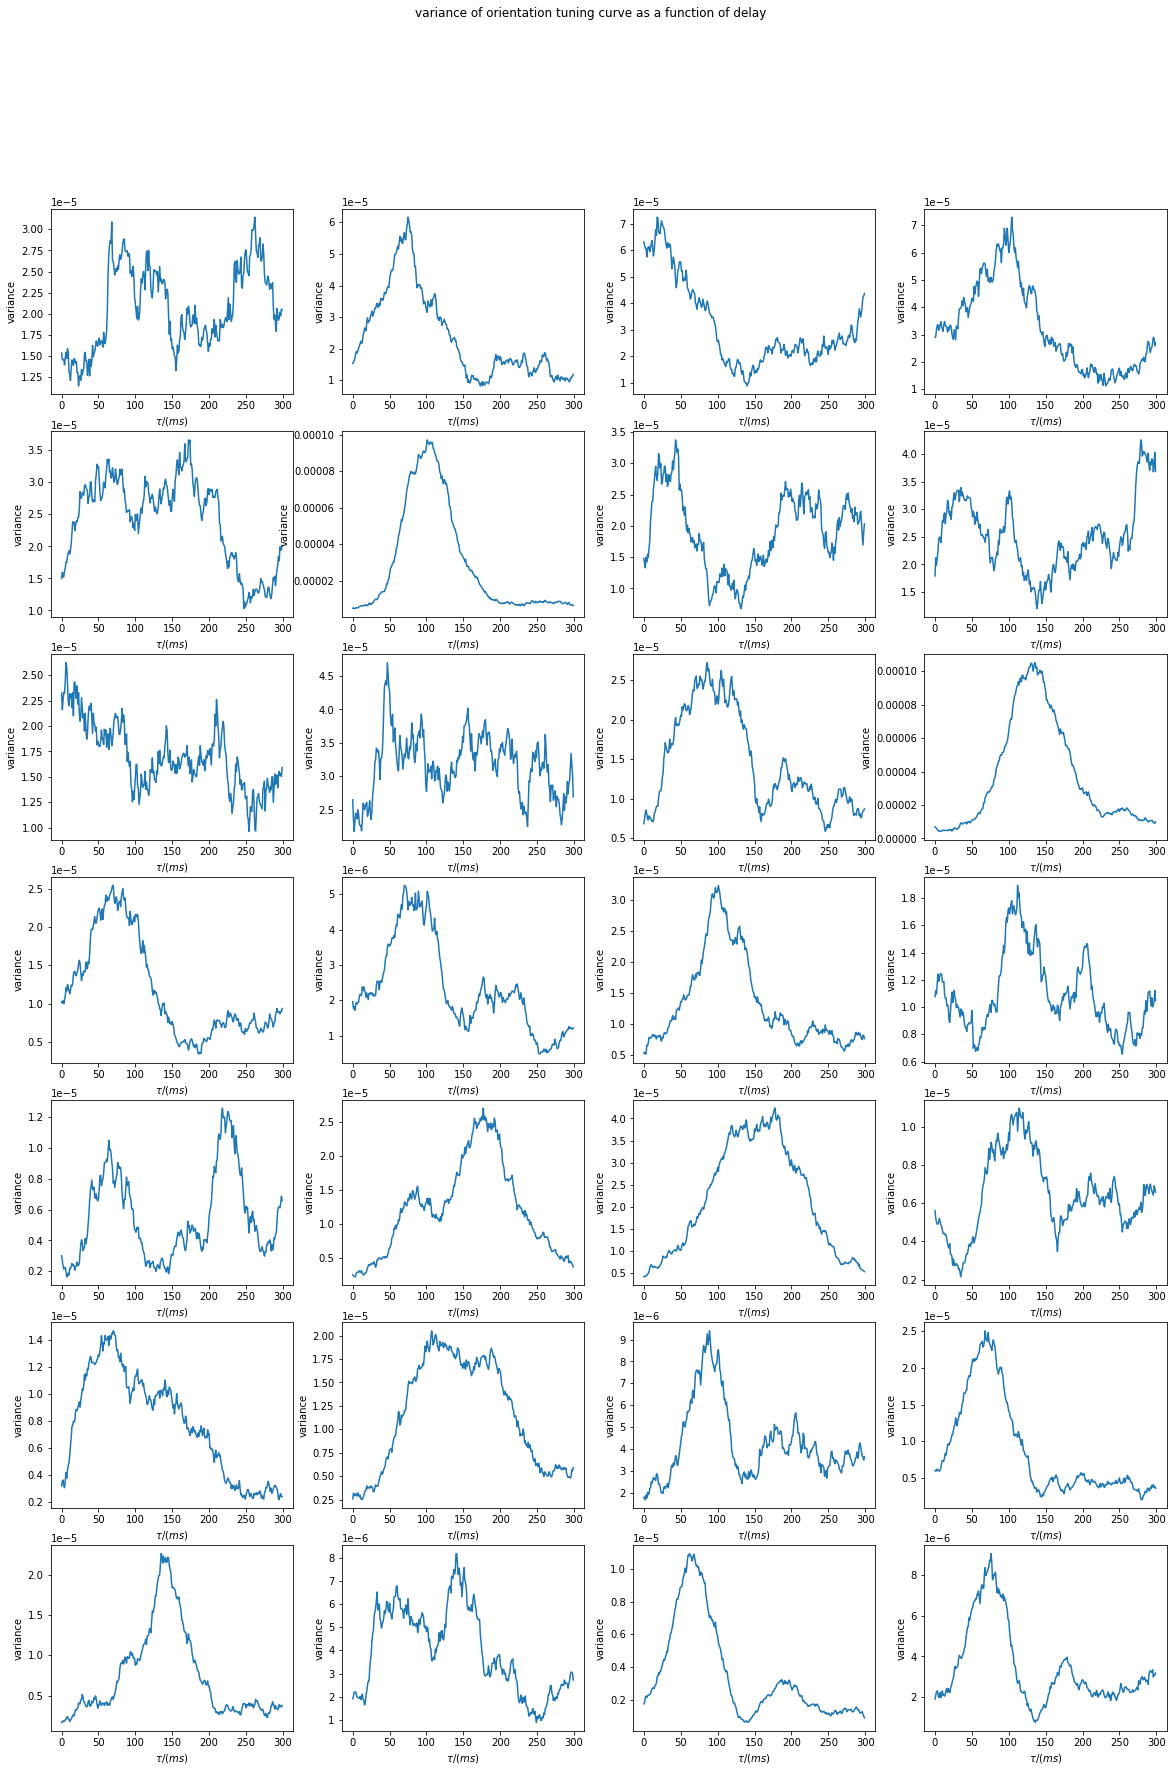

In [ ]:
%matplotlib inline

key = 'orientation'
fig, ax = plt.subplots(7,4,figsize=(5*4, 7*4))
for unit_id in range(num_unit):
    ax[unit_id//4, unit_id%4].plot(var_tuning[key][unit_id])
    ax[unit_id//4, unit_id%4].set_ylabel('variance')
    ax[unit_id//4, unit_id%4].set_xlabel('$\\tau/(ms)$')

fig.suptitle('variance of orientation tuning curve as a function of delay')
plt.show()

In [ ]:
%matplotlib inline
@widgets.interact(tau_id = widgets.IntSlider(0, min=0, max=max_delay-1, description='delay/ms'))

def TwoDimTuning(tau_id):
    unit_selection = [0,1,2,3]

    fig, ax = plt.subplots(1, 4, figsize=(5*4, 1*4))
    for i, unit_id in enumerate(unit_selection):
        ax[i].imshow(avg_firing_rate_pair[unit_id, tau_id], interpolation='None', cmap='jet')

        ax[i].set_xticks(np.arange(20)[::5])
        ax[i].set_xticklabels(stim_val['phase'][::5])
        ax[i].set_yticks(np.arange(20)[::5])
        ax[i].set_yticklabels(stim_val['orientation'][::5])
        ax[i].set_xlabel('phase')
        ax[i].set_ylabel('orientation')
        ax[i].set_title('delay:%d'%tau_id +' unit %d'%unit_id + ', spike num: %d'%sorted_spike_num[unit_id])
        
    plt.show()

interactive(children=(IntSlider(value=0, description='delay/ms', max=299), Output()), _dom_classes=('widget-in…

### Klein bottle symmetry: Continuity at parametrization boundary?

In [ ]:
# klein bottle symmetry

%matplotlib inline

@widgets.interact(tau_id=widgets.IntSlider(0, min=0, max=len(tau_id_range)-1, description='delay/ms'), phase_ref = widgets.IntSlider(10, min=0, max=19, description='phase reference'))

def klein_bottle(tau_id, phase_ref):
    unit_selection = [0,1,2,3]
    klein_bottle_rate = np.zeros((num_unit, 40, 40))

    fig, ax = plt.subplots(1, 4, figsize=(5*4, 1*4))
    for i, unit_id in enumerate(unit_selection):
        x = np.hstack((avg_firing_rate_pair[unit_id,tau_id], avg_firing_rate_pair[unit_id,tau_id]))
        y = np.hstack((x[:,phase_ref:], x[:, :phase_ref]))
        klein_bottle_rate[unit_id] = np.vstack((x, y[:,::-1]))
        ax[i].imshow(klein_bottle_rate[unit_id], interpolation='None', cmap='jet')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].plot(np.arange(40), 19.5*np.ones(40), 'r', linewidth=0.5)
        ax[i].plot(19.5*np.ones(40), np.arange(40), 'r', linewidth=0.5)

        ax[i].set_xlabel('phase')
        ax[i].set_ylabel('orientation')
        
    plt.show()

interactive(children=(IntSlider(value=0, description='delay/ms', max=299), IntSlider(value=10, description='ph…

In [ ]:
stim_val_2cycle = {}
x = np.copy(stim_val['orientation'])
y = np.concatenate((x, x+180))
stim_val_2cycle['orientation'] = np.concatenate((y,y))

x = np.copy(stim_val['phase'])
stim_val_2cycle['phase'] = np.concatenate((x, x))

for key in key_list[1:]:
    stim_val_2cycle[key] = list(map(int, stim_val_2cycle[key]))

In [ ]:
# klein bottle symmetry

    
@widgets.interact(grid=widgets.RadioButtons(options=['ON', 'OFF'], disabled=False), tau_id=widgets.IntSlider(60, min=0, max=len(tau_id_range)-1, description='delay/ms'), 
phase_ref = widgets.IntSlider(10, min=0, max=19, description='phase reference'),
ticks = widgets.RadioButtons(options=['ON', 'OFF'], disabled=False))

def klein_bottle(grid, ticks, phase_ref, tau_id):
    klein_bottle_rate = np.zeros((num_unit, 80, 40))

    fig, ax = plt.subplots(10, 4, figsize=(5*4, 10*4))
    for unit_id in range(num_unit):
        x = np.hstack((avg_firing_rate_pair[unit_id,tau_id], avg_firing_rate_pair[unit_id,tau_id]))
        y = np.hstack((x[:,phase_ref:], x[:, :phase_ref]))
        z = np.vstack((x, y[:,::-1]))
        klein_bottle_rate[unit_id] = np.vstack((z,z))
        ax[unit_id//4, unit_id%4].imshow(klein_bottle_rate[unit_id], interpolation='None', cmap='jet', aspect=0.5)
        ax[unit_id//4, unit_id%4].set_xticks([])
        ax[unit_id//4, unit_id%4].set_yticks([])
        
        if grid=='ON':
            ax[unit_id//4, unit_id%4].plot(np.arange(40), 19.5*np.ones(40), 'r', linewidth=0.5)
            ax[unit_id//4, unit_id%4].plot(np.arange(40), (19.5 + 20)*np.ones(40), 'r', linewidth=0.5)
            ax[unit_id//4, unit_id%4].plot(np.arange(40), (19.5 + 40)*np.ones(40), 'r', linewidth=0.5)
            ax[unit_id//4, unit_id%4].plot(19.5*np.ones(80), np.arange(80), 'r', linewidth=0.5)
            ax[unit_id//4, unit_id%4].plot((19.5 + 10)*np.ones(80), np.arange(80), 'r', linewidth=0.5)
            ax[unit_id//4, unit_id%4].plot((19.5 - 10)*np.ones(80), np.arange(80), 'r', linewidth=0.5)

        if ticks=='ON':
            ax[unit_id//4, unit_id%4].set_xticks(np.arange(40)[::5])
            ax[unit_id//4, unit_id%4].set_yticks(np.arange(80)[::10])
            
            ax[unit_id//4, unit_id%4].set_yticklabels(stim_val_2cycle['orientation'][::10])
            ax[unit_id//4, unit_id%4].set_xticklabels(stim_val_2cycle['phase'][::5])

        ax[unit_id//4, unit_id%4].set_xlabel('phase')
        ax[unit_id//4, unit_id%4].set_ylabel('orientation')
        
    plt.show()

interactive(children=(RadioButtons(description='grid', options=('ON', 'OFF'), value='ON'), RadioButtons(descri…

So we see that a phase reference shift of 180 is necessary.

$\theta \rightarrow \theta + \pi$

$\phi \rightarrow \pi -\phi$

or equivalently

$\phi - \frac{\pi}{2} \rightarrow \frac{\pi}{2} - \phi$

which means that the proper phase reference that is maintained is at $\pi/2$

i.e. at $\phi=\pi/2$ the orientation loop is of period $180$ degrees instead of $360$ degrees. So at $\phi=0$ the center of rotation is on the border (exactly in the middle of contrast extrema) between black and white stripes.

Another transformation (?)

$\theta \rightarrow \pi - \theta$ (But this is clearly wrong)

$\phi \rightarrow \phi - \pi$


In [ ]:
# # relabelling
# param = np.arange(400).reshape(20,20)
# phase_ref = 10
# x = param[:, :phase_ref]
# y = param[:, phase_ref:]
# reparam = np.vstack((x, y[:,::-1]))
# stim_val_reparam = {}
# stim_val_reparam['phase'] = stim_val['phase'][:phase_ref]/2
# stim_val_reparam['orientation'] = np.concatenate((stim_val['orientation'], stim_val['orientation']+180))


# stim_val_reparam['pair'] = stim_val['pair'][reparam]

# stim_val_reparam['pair'] = stim_val['pair']
# for x in stim_val['pair']:
#     if x[1]>= 180:
#         x[0] += 180
#         x[1] = phase_ref - x[1]

# stim_val['pair'][reparam]
# stim_val['pair'].shape
# plt.imshow(reparam%20)

Dimensionality Reduction

In [ ]:
import sys
sys.path.insert(0, './Persistent_Homology')

from gratings import grating_model
from plotting import plot_data, plot_mean_against_index, show_feature
from persistence import persistence
from decoding import cohomological_parameterization, remove_feature
from noisereduction import PCA_reduction, z_cutoff, density_filtration
from sklearn.decomposition import PCA 

# relabelling
param = np.arange(400).reshape(20,20)
phase_ref = 10
x = param[:phase_ref]
reparam = np.vstack((x, x[:,::-1]))
stim_val_reparam = {}
stim_val_reparam['phase'] = stim_val['phase'][:phase_ref]
stim_val_reparam['orientation'] = np.concatenate((stim_val['orientation'], stim_val['orientation']+180))

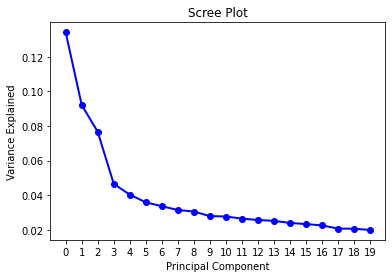

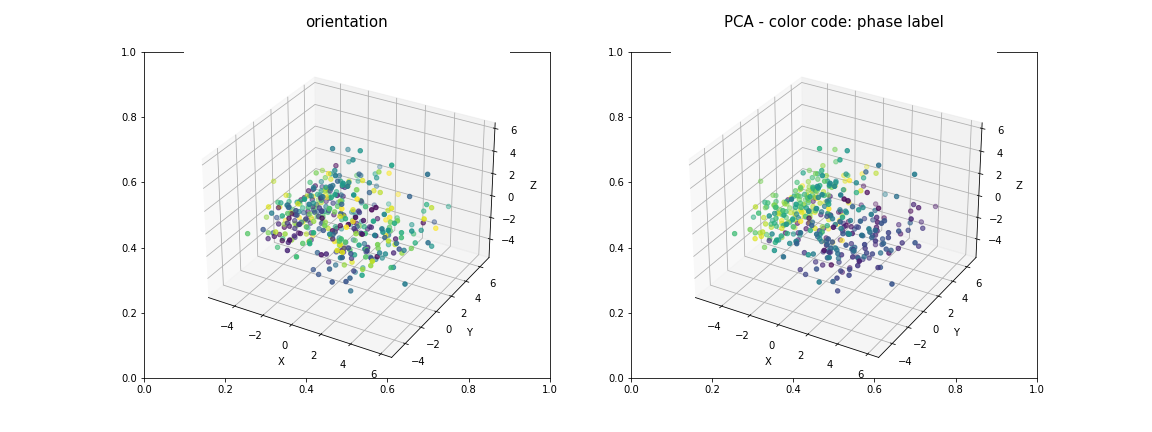

In [ ]:
tau_id = 60
Z = sts.zscore(stim_hist['pair'][:, tau_id, :].T, axis=0)
# Z = Z[:, np.logical_not(np.isnan(Z[0]))]
# n_components = len(Z[0])
n_components = 20
pca = PCA(n_components)
X = pca.fit_transform(Z)
%matplotlib inline
PC_values = np.arange(n_components)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xticks(np.arange(20))
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0] = fig.add_subplot(1, 2, 1, projection='3d')
x, y, z = X[:,0], X[:,1], X[:,2]
ax[0].scatter3D(x, y, z, c=stim_val['pair'][:,0])
ax[0].set_title("orientation", pad=25, size=15)
ax[0].set_xlabel("X") 
ax[0].set_ylabel("Y") 
ax[0].set_zlabel("Z")

ax[1] = fig.add_subplot(1, 2, 2, projection='3d')
x, y, z = X[:,0], X[:,1], X[:,2]
ax[1].scatter3D(x, y, z, c=stim_val['pair'][:,1])
ax[1].set_title("PCA - color code: phase label", pad=25, size=15)
ax[1].set_xlabel("X") 
ax[1].set_ylabel("Y") 
ax[1].set_zlabel("Z")
plt.show()

# PCA

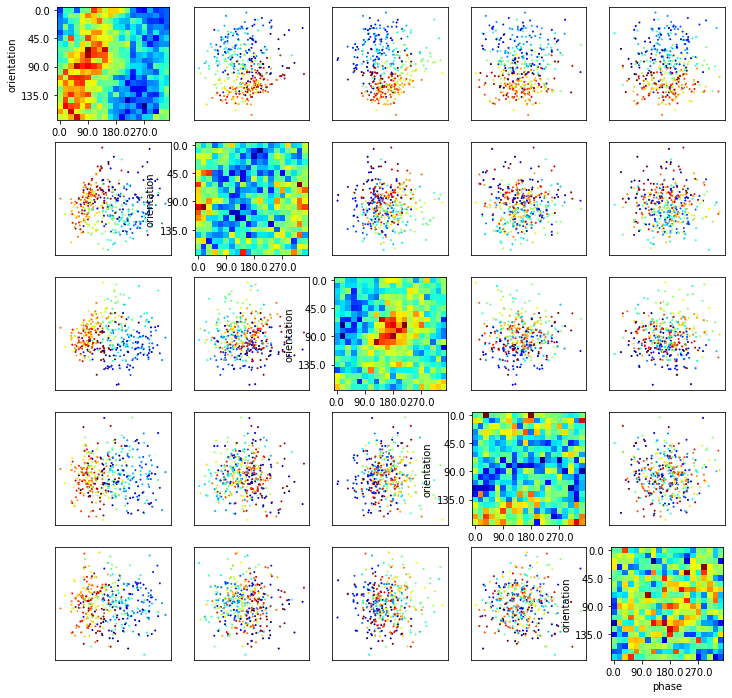

In [ ]:
%matplotlib inline
ncomp = 5
X_reduced = X[:,:ncomp]
# xmin, xmax = -2*np.std(X_reduced)+np.mean(X_reduced), 2*np.std(X_reduced)+np.mean(X_reduced)
fig = plt.figure(figsize=(12,12))
for i in range(ncomp):
    for j in range(ncomp):
        ax = plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
        if i==j:
            ax.imshow(X_reduced[:,i].reshape(20,20), interpolation='None', cmap='jet')
            ax.set_xticks(np.arange(20)[::5])
            ax.set_xticklabels(stim_val['phase'][::5])
            ax.set_yticks(np.arange(20)[::5])
            ax.set_yticklabels(stim_val['orientation'][::5])
            ax.set_xlabel('phase')
            ax.set_ylabel('orientation')

        else:
            ax.scatter(X_reduced[:,j], X_reduced[:,i], s=1, c=stim_val['pair'][:,1], cmap='jet')
            # ax.set_xlim([xmin, xmax])
            ax.set_xticks([])

            # ax.set_ylim([xmin, xmax])
            ax.set_yticks([])
            
# fig.suptitle('n_neighbors: %d'%n_neighbors)

In [ ]:
embed = {5:np.load('embed3d_n_neighbors5.npy'), 20:np.load('embed3d_n_neighbors20.npy'), 50:np.load('embed3d_n_neighbors50.npy')}

In [ ]:
def show_umap(embed, n_neighbors):
    %matplotlib inline
    ncomp = embed.shape[1]
    # xmin, xmax = -2*np.std(embed)+np.mean(embed), 2*np.std(embed)+np.mean(embed)
    fig = plt.figure(figsize=(12,12))
    for i in range(ncomp):
      for j in range(ncomp):
        ax = plt.subplot(ncomp,ncomp, j + ncomp*i + 1)
        if i==j:
          ax.imshow(embed[:,i].reshape(20,20), interpolation='None', cmap='jet')
          ax.set_xticks(np.arange(20)[::5])
          ax.set_xticklabels(stim_val['phase'][::5])
          ax.set_yticks(np.arange(20)[::5])
          ax.set_yticklabels(stim_val['orientation'][::5])
          ax.set_xlabel('phase')
          ax.set_ylabel('orientation')

        else:
          ax.scatter(embed[:,j], embed[:,i], s=1, c=stim_val['pair'][:,1], cmap='jet')
          # ax.set_xlim([xmin, xmax])
          ax.set_xticks([])

          # ax.set_ylim([xmin, xmax])
          ax.set_yticks([])
          
    fig.suptitle('n_neighbors: %d'%n_neighbors)

n_neighbors. This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data.

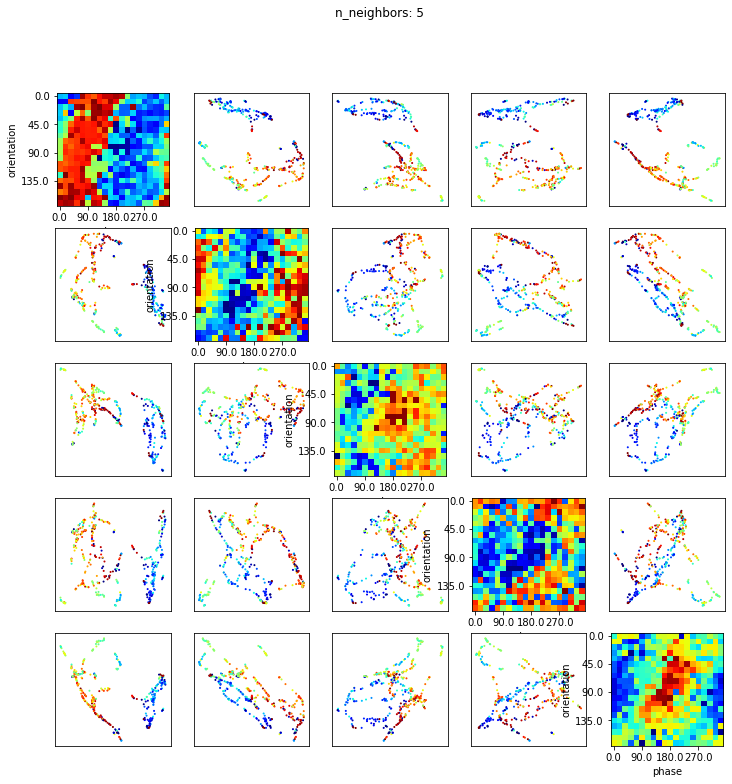

In [ ]:
n_neighbors = 5
show_umap(embed[n_neighbors], n_neighbors=n_neighbors)

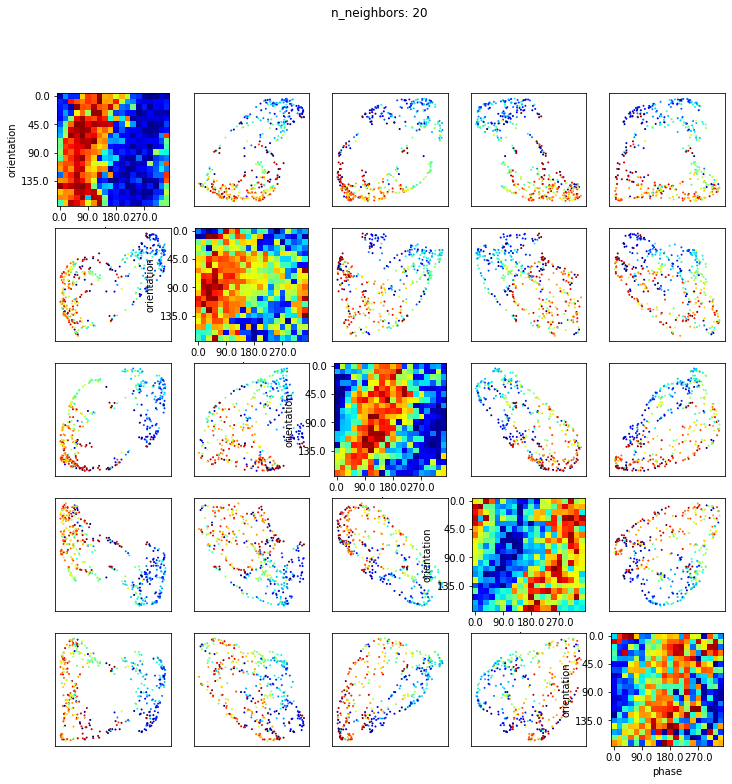

In [ ]:
n_neighbors = 20
show_umap(embed[n_neighbors], n_neighbors=n_neighbors)

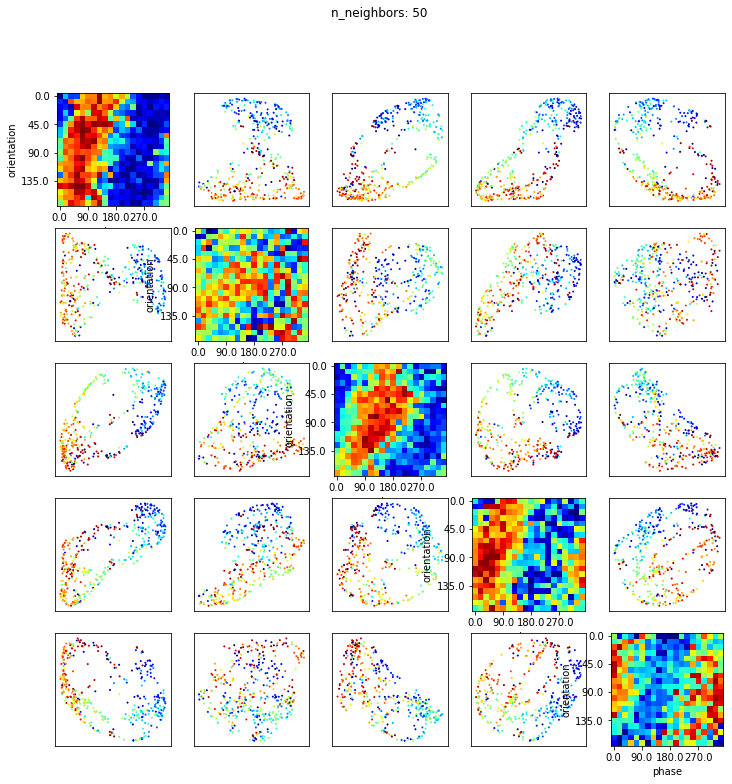

In [ ]:
n_neighbors = 50
show_umap(embed[n_neighbors], n_neighbors=n_neighbors)

## Cohomological Decoding on UMAP

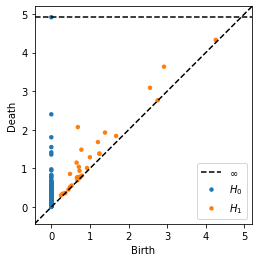

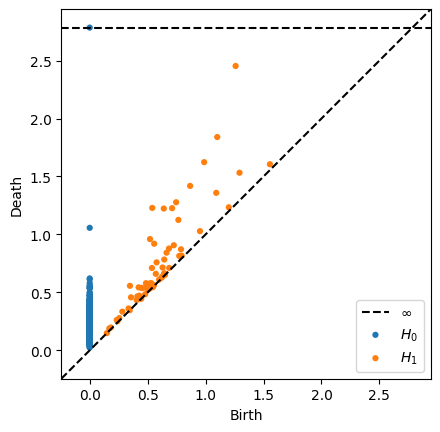

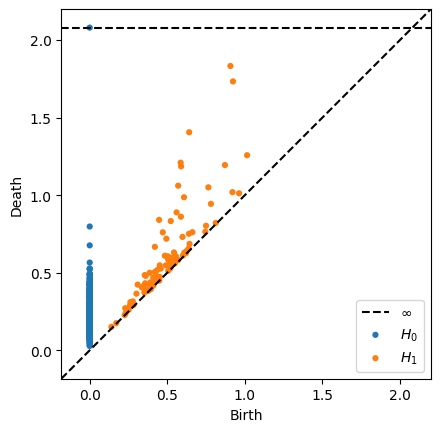

In [ ]:
%matplotlib inline
persistence(pd.DataFrame(embed[5]),homdim=1,coeff=2)
persistence(pd.DataFrame(embed[20]),homdim=1,coeff=2)
persistence(pd.DataFrame(embed[50]),homdim=1,coeff=2)

In [ ]:
file = open('decoding50.pkl', 'rb')
decoding50 = pickle.load(file)
file.close()

decoding50['phase'] = stim_val['pair'][decoding50.index][:,1]
decoding50['orientation'] = stim_val['pair'][decoding50.index][:,0]
def phasor_avg(x, period):
    return np.angle(np.sum(np.exp(2*np.pi*1j*x/period)))*180/np.pi + 180

statistic, bin_edges, bin_number = sts.binned_statistic(decoding50['decoding'], decoding50['phase'], lambda x:phasor_avg(x, period=360), 20)

In [ ]:
statistic

array([137.14126279, 220.09508264, 175.41479907, 153.        ,
       162.        , 112.86104702,  95.45882883,  66.83662297,
        29.00746987, 354.46203037,  12.11351122,   5.80639544,
       354.02211424, 234.        , 342.        , 314.12816312,
       272.63321064, 229.74777269, 207.23795075, 212.06151078])

In [ ]:
np.arange(10)[::3]

array([0, 3, 6, 9])

In [ ]:
stim_val['phase'][::3]

array([  0.,  54., 108., 162., 216., 270., 324.])

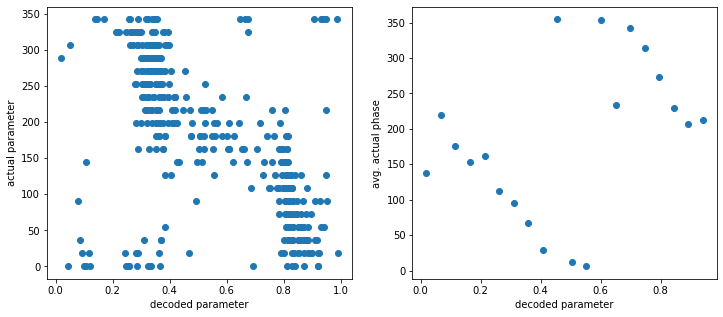

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(decoding50['decoding'], stim_val['pair'][decoding50.index][:,1])
ax[0].set_xlabel('decoded parameter')
ax[0].set_ylabel('actual parameter')

ax[1].scatter(bin_edges[:-1], statistic)
ax[1].set_ylabel('avg. actual phase')
ax[1].set_xlabel('decoded parameter')
plt.show()

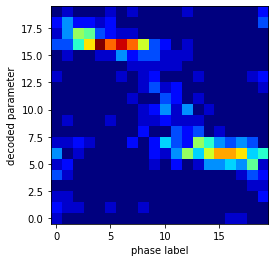

In [ ]:
hist2d, xbin, ybin = np.histogram2d(decoding50['decoding'], stim_val['pair'][decoding50.index][:,1], bins=20)
fig, ax = plt.subplots(1,1)
ax.imshow(hist2d)
ax.set_xlabel('phase label')
ax.set_ylabel('decoded parameter')
# ax.set_xticklabels
# ax.set_yticks(xbin[:-1])
ax.invert_yaxis()
plt.show()

## UMAP fixed $\phi$

In [ ]:
# fix phase at 90
phase_id = 5
phase_sec_id = stim_val['pair'][:,1] == stim_val['phase'][phase_id]

## UMAP fixed $\phi^\prime$